In [1]:
import pandas as pd

data = pd.read_csv('city.csv')
data = data.loc[data['population'].nlargest(30).index]

In [9]:
import numpy as np
from haversine import haversine

class SA:
    def __init__(
        self, data,
        annealing_rate=0.999,
        start_temp=100000,
        cooldown=1e-6
    ):
        self.data = data
        self.cooldown = cooldown
        self.nodes = {}
        for index, row in self.data.iterrows():
            self.nodes[index] = (row['geo_lat'], row['geo_lon'])
        self.step_number = 0
        self.annealing_rate = annealing_rate
        self.temperature = start_temp
        self.path = np.array([*self.nodes.keys()])
        np.random.shuffle(np.array([*self.nodes.keys()]))
        self.cost = self.calculate_cost(self.path)
        self.res = []

    def step(self):
        neighbour_path = self._neighbour()
        neighbour_cost = self.calculate_cost(neighbour_path)
        coin_flip = np.random.uniform()
        threshold = np.exp(-neighbour_cost/self.temperature)
        if neighbour_cost < self.cost or coin_flip < threshold:
            self.path = neighbour_path
            self.cost = neighbour_cost
        self.temperature *= self.annealing_rate
        self.step_number += 1

    def solve(self):
        f = open("statistics.csv", 'w')
        f.close()
        while self.temperature >= self.cooldown:
            self.step()
            self.res.append([self.step_number, self.cost])

    def calculate_cost(self, path):
        distances = []
        for i in range(len(self.path) - 1):
            left_node = self.nodes[path[i]]
            right_node = self.nodes[path[i + 1]]
            distances.append(haversine(left_node, right_node))
        return sum(distances)

    def _neighbour(self):
        left_idx, right_idx = np.random.choice(len(self.path), size=2)
        pth = self.path.copy()
        pth[left_idx], pth[right_idx] = pth[right_idx], pth[left_idx]
        return pth

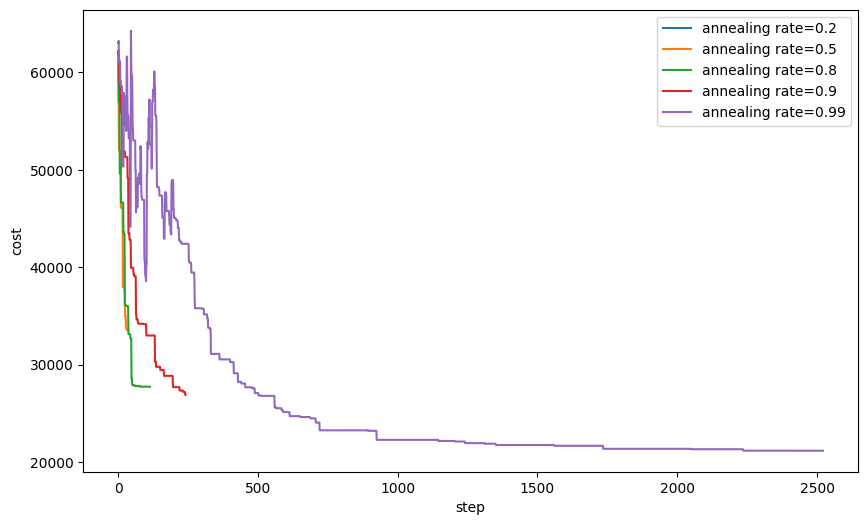

In [14]:
import matplotlib.pyplot as plt

rates = [0.2, 0.5, 0.8, 0.9, 0.99]
plt.figure(figsize=(10,6))
for rate in rates:
    sa = SA(data, rate)
    sa.solve()
    res = np.array(sa.res)
    plt.plot(res[:, 0], res[:, 1], label=f'annealing rate={rate}')
plt.xlabel("step")
plt.ylabel("cost")
plt.legend()
plt.show()